# Workflow Examples 


`xclim` is built on very powerful multiprocessing and distributed computation libraries, notably `xarray` and `dask`.

`xarray` is a python package making it easy to work with n-dimensional arrays. It labels axes with their names `[time, lat, lon, level]` instead of indices `[0,1,2,3]`, reducing the likelihood of bugs and making the code easier to understand. One of the key strengths of `xarray` is that it knows how to deal with non-standard calendars (we're looking at you, "`360_days`") and can easily resample daily time series to weekly, monthly, seasonal or annual periods.  Finally, `xarray` is tightly inegrated with `dask`, a package that can automatically parallelize operations.

The following are a few examples to consult when using `xclim` to subset netCDF arrays and compute climate indicators, taking advantage of the parallel processing capabilities offered by `xarray` and `dask`. For more information about these projects, please see their documentation pages:

* [xarray documentation](https://xarray.pydata.org/en/stable/)
* [dask documentation](https://docs.dask.org/en/stable/)

## Environment configuration

In [1]:
# Imports for xclim and xarray
import xclim as xc
import numpy as np
import xarray as xr
xr.set_options(display_style='html')

# File handling libraries
import time
import tempfile
from pathlib import Path

# Output folder
output_folder = Path(tempfile.mkdtemp()) 

## Setting up the Dask client: parallel processing


<div class="alert alert-info">

In this example, we are using the **dask.distributed** submodule. This is not installed by default in a basic `xclim` installation. Be sure to add `distributed` to your Python installation before setting up parallel processing operations!
    
</div>

First we create a pool of workers that will wait for jobs. The `xarray` library will automatically connect to these workers and and dispatch them jobs that can be run in parallel.  

The dashboard link lets you see in real time how busy those workers are.

* [dask distributed documentation](https://distributed.dask.org/en/latest/)

This step is not mandatory as dask will fall back to its "single machine scheduler" if a `Client` is not created. However, this default scheduler doesn't allow you to set the number of threads or a memory limit and doesn't start the dashboard, which can be quite useful to understand your task's progress.


In [2]:
from distributed import Client

# Depending on your workstation specifications, you may need to adjust these values.
# On a single machine, n_workers=1 is usually better.
client=Client(n_workers=1, threads_per_worker=4, memory_limit="4GB") 
client

Client Scheduler: tcp://127.0.0.1:46859 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 4.00 GB


## Creating xarray datasets

To open a netCDF file with `xarray`, we use `xr.open_dataset(<path to file>)`. By default, the entire file is stored in one chunk, so there is no parallelism. To trigger parallel computations, we need to explicitly specify the **chunk size**. 

<div class="alert alert-info">

In this example, instead of opening a local file, we pass an *OPeNDAP* url to xarray. It retrieves the data automatically. Notice also that opening the dataset is quite fast. In fact, the data itself has not been downloaded yet, only the coordinates and the metadata. The downloads will be triggered only when the values need to be accessed directly.

</div>

`dask`'s parallelism is based on memory chunks. We need to tell `xarray` to split our netCDF array into chunks of a given size, and operations on each chunk of the array will automatically be dispatched to the workers. 

In [3]:
data_url = 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/simulations/bias_adjusted/cmip5/ouranos/cb-oura-1.0/day_ACCESS1-3_historical+rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.ncml'

In [4]:
# Chunking in memory along the time dimension.
# Note that the data type is a 'dask.array'. xarray will automatically use client workers.
ds = xr.open_dataset(data_url, chunks={'time': 365, 'lat': 168, 'lon': 150}, drop_variables=['ts', 'time_vectors'])
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 320, lon: 797, time: 55152)
Coordinates:
  * lat      (lat) float32 66.62331 66.53998 66.45665 ... 40.12437 40.04104
  * lon      (lon) float32 -120.79394 -120.71061 ... -54.54659 -54.46326
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2100-12-31
Data variables:
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(365, 168, 150), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(365, 168, 150), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(365, 168, 150), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.5
    title:                      Ouranos standard ensemble of bias-adjusted cl...
    history:                    CMIP5 compliant file produced from raw ACCESS...
    institution:                Ouranos Consortium on Regional Climatology an...
    source:                     ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 gr...
    driving_model:              

In [5]:
print(ds.tasmin.chunks)

((365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 37), (168, 152), (150, 150, 150, 150, 150, 47))


## Multi-file datasets

NetCDF files are often split into periods to keep file size manageable. A single dataset can be split in dozens of individual files. `xarray` has a function `open_mfdataset` that can open and aggregate a list of files and construct a unique *logical* dataset. `open_mfdataset` can aggregate files over coordinates (time, lat, lon) and variables. 

* Note that opening a multi-file dataset automatically chunks the array (one chunk per file).
* Note also that because `xarray` reads every file metadata to place it in a logical order, it can take a while to load. 

In [6]:
## Create multi-file data & chunks 
# ds = xr.open_mfdataset('/path/to/files*.nc')

## Subsetting and selecting data with xarray
Usually, xclim users are encouraged to use the subsetting utilities of the [clisops](https://clisops.readthedocs.io/en/latest/notebooks/subset.html) package. Here, we will reduce the size of our data using the methods implemented in xarray ([docs here](http://xarray.pydata.org/en/stable/indexing.html)).

In [7]:
ds2 = ds.sel(lat=slice(50, 45), lon=slice(-70, -65), time=slice('2090', '2100'))
print(ds2.tasmin)

<xarray.DataArray 'tasmin' (time: 4017, lat: 60, lon: 60)>
dask.array<getitem, shape=(4017, 60, 60), dtype=float32, chunksize=(365, 60, 60), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 49.95731 49.87398 49.79065 ... 45.12417 45.04084
  * lon      (lon) float32 -69.96264 -69.87931 -69.79598 ... -65.1295 -65.04617
  * time     (time) datetime64[ns] 2090-01-01 2090-01-02 ... 2100-12-31
Attributes:
    long_name:      air_temperature
    standard_name:  air_temperature
    units:          K
    _ChunkSizes:    [256  16  16]


In [8]:
ds3 = ds.sel(lat=46.8, lon=-71.22, method='nearest').sel(time='1993')
print(ds3.tasmin)

<xarray.DataArray 'tasmin' (time: 365)>
dask.array<getitem, shape=(365,), dtype=float32, chunksize=(354,), chunktype=numpy.ndarray>
Coordinates:
    lat      float32 46.79077
    lon      float32 -71.21259
  * time     (time) datetime64[ns] 1993-01-01 1993-01-02 ... 1993-12-31
Attributes:
    long_name:      air_temperature
    standard_name:  air_temperature
    units:          K
    _ChunkSizes:    [256  16  16]


## Climate index calculation & resampling frequencies

`xclim` has two layers for the calculation of indicators. The bottom layer is composed of a list of functions that take one or more `xarray.DataArray`'s as input and return an `xarray.DataArray` as output. You'll find these functions in `xclim.indices`. The indicator's logic is contained in this function, as well as potential unit conversions, but it doesn't perform any data consistency checks (like if the time frequency is daily), and doesn't not adjust the meta data of the output array. 

The second layer are class instances that you'll find organized by *realm*. So far, there are three realms available in `xclim.atmos`, `xclim.seaIce` and `xclim.land`, the first one being the most exhaustive. Before running computations, these classes check if the input data is a daily average of the expected variable:

1. If an indicator expects a daily mean and you pass it a daily max, a `warning` will be raised. 
2. After the computation, it also checks the number of values per period to make sure there are not missing values or `NaN` in the input data. If there are, the output is going to be set to `NaN`.  Ex. : If the indicator performs a yearly resampling but there are only 350 non-`NaN` values in one given year in the input data, that year's output will be `NaN`.
3. The output units are set correctly as well as other properties of the output array, complying as much as possible with CF conventions. 

For new users, we suggest you use the classes found in `xclim.atmos` and others. If you know what you're doing and you want to circumvent the built-in checks, then you can use the `xclim.indices` directly. 

Almost all `xclim` indicators convert daily data to lower time frequencies, such as seasonal or annual values. This is done using `xarray.DataArray.resample` method. Resampling creates a grouped object over which you apply a reduction operation (e.g. mean, min, max). The list of available frequency is given in the link below, but the most often used are: 

- `YS`: annual starting in January
- `YS-JUL`: annual starting in July
- `MS`: monthly
- `QS-DEC`: seasonal starting in December

More info about this specification can be found in [pandas' documentation](http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases)

Note - not all offsets in the link are supported by cftime objects in `xarray`.


In the example below, we're computing the **annual maximum temperature of the daily maximum temperature (tx_max)**.

In [9]:
out = xc.atmos.tx_max(ds2.tasmax, freq='YS')
print(out)

<xarray.DataArray 'tx_max' (time: 11, lat: 60, lon: 60)>
dask.array<where, shape=(11, 60, 60), dtype=float32, chunksize=(1, 60, 60), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2090-01-01 2091-01-01 ... 2100-01-01
  * lat      (lat) float32 49.95731 49.87398 49.79065 ... 45.12417 45.04084
  * lon      (lon) float32 -69.96264 -69.87931 -69.79598 ... -65.1295 -65.04617
Attributes:
    long_name:      Maximum daily maximum temperature
    standard_name:  air_temperature
    units:          K
    _ChunkSizes:    [256  16  16]
    cell_methods:    time: maximum within days time: maximum over days
    xclim_history:  [2021-01-21 17:18:05] tx_max: tx_max(tasmax=<array>, freq...
    description:    Annual maximum of daily maximum temperature.


/home/tjs/git/xclim/xclim/indicators/atmos/_temperature.py:87: UserWarning: Variable does not have a `cell_methods` attribute.
  cfchecks.check_valid(tasmax, "cell_methods", "*time: maximum within days*")
/home/tjs/miniconda3/envs/xclim38/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/home/tjs/miniconda3/envs/xclim38/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


<div class="alert alert-info">

If you execute the cell above, you'll see that this operation is quite fast. This a feature coming from dask. Read *Lazy computation*  further down.

</div>

### Comparison of **atmos** vs **indices** modules
Using the `xclim.indices` module performs not checks and only fills the `units` attribute.

In [10]:
out = xc.indices.tx_days_above(ds2.tasmax, thresh='30 C', freq='YS')
print(out)

<xarray.DataArray 'tasmax' (time: 11, lat: 60, lon: 60)>
dask.array<stack, shape=(11, 60, 60), dtype=int64, chunksize=(1, 60, 60), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2090-01-01 2091-01-01 ... 2100-01-01
  * lat      (lat) float32 49.95731 49.87398 49.79065 ... 45.12417 45.04084
  * lon      (lon) float32 -69.96264 -69.87931 -69.79598 ... -65.1295 -65.04617
Attributes:
    units:    days


/home/tjs/miniconda3/envs/xclim38/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


With `xclim.atmos`, checks are performed and many CF-compliant attributes are added:

In [11]:
out = xc.atmos.tx_days_above(ds2.tasmax, thresh='30 C', freq='YS')
print(out)

/home/tjs/git/xclim/xclim/indicators/atmos/_temperature.py:87: UserWarning: Variable does not have a `cell_methods` attribute.
  cfchecks.check_valid(tasmax, "cell_methods", "*time: maximum within days*")
/home/tjs/miniconda3/envs/xclim38/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/home/tjs/miniconda3/envs/xclim38/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


<xarray.DataArray 'tx_days_above' (time: 11, lat: 60, lon: 60)>
dask.array<where, shape=(11, 60, 60), dtype=float64, chunksize=(1, 60, 60), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2090-01-01 2091-01-01 ... 2100-01-01
  * lat      (lat) float32 49.95731 49.87398 49.79065 ... 45.12417 45.04084
  * lon      (lon) float32 -69.96264 -69.87931 -69.79598 ... -65.1295 -65.04617
Attributes:
    units:          days
    cell_methods:    time: maximum within days time: sum over days
    xclim_history:  [2021-01-21 17:18:05] tx_days_above: tx_days_above(tasmax...
    standard_name:  number_of_days_with_air_temperature_above_threshold
    long_name:      Number of days with tmax > 30 c
    description:    Annual number of days where daily maximum temperature exc...


In [12]:
# We have created an xarray data-array - We can insert this into an output xr.Dataset object with a copy of the original dataset global attrs
dsOut = xr.Dataset(attrs=ds2.attrs)

# Add our climate index as a data variable to the dataset
dsOut[out.name] = out
print(dsOut)

<xarray.Dataset>
Dimensions:        (lat: 60, lon: 60, time: 11)
Coordinates:
  * time           (time) datetime64[ns] 2090-01-01 2091-01-01 ... 2100-01-01
  * lat            (lat) float32 49.95731 49.87398 ... 45.12417 45.04084
  * lon            (lon) float32 -69.96264 -69.87931 ... -65.1295 -65.04617
Data variables:
    tx_days_above  (time, lat, lon) float64 dask.array<chunksize=(1, 60, 60), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.5
    title:                      Ouranos standard ensemble of bias-adjusted cl...
    history:                    CMIP5 compliant file produced from raw ACCESS...
    institution:                Ouranos Consortium on Regional Climatology an...
    source:                     ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 gr...
    driving_model:              ACCESS1-3
    driving_experiment:         historical,rcp85
    institute_id:               Ouranos
    type:                       GCM
    processing:                 bias_adjus

## *Lazy* computation - Nothing has been computed so far !

If you look at the output of those operations, they're identified as `dask.array` objects. What happens is that `dask` creates a chain of operations that when executed, will yield the values we want. We have thus far only created a schedule of tasks with a small preview and not done any actual computations. You can trigger computations by using the `load` or `compute` method, or writing the output to disk via `to_netcdf`. Of course, calling `.plot()` will also trigger the computation.

In [13]:
%%time
output_file = output_folder / 'test_tx_max.nc'
dsOut.to_netcdf(output_file)

CPU times: user 1.52 s, sys: 150 ms, total: 1.67 s
Wall time: 35.9 s


*(Times may of course vary depending on the machine and the Client settings)*

### Performance tips
#### Optimizing the chunk size

You can improve performance by being smart about chunk sizes. If chunks are too small, there is a lot of time lost in overhead. If chunks are too large, you may end up exceeding the individual worker memory limit.

In [14]:
print(ds2.chunks['time'])

(330, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 37)


In [15]:
# rechunk data in memory for the entire grid  
ds2c = ds2.chunk(chunks={'time':4 * 365})
print(ds2c.chunks['time'])

(1460, 1460, 1097)


In [16]:
%%time
out = xc.atmos.tx_max(ds2c.tasmax, freq='YS')
dsOut = xr.Dataset(data_vars=None, coords=out.coords, attrs=ds.attrs)
dsOut[out.name] = out

output_file = output_folder / 'test_tx_max.nc'
dsOut.to_netcdf(output_file)

/home/tjs/git/xclim/xclim/indicators/atmos/_temperature.py:87: UserWarning: Variable does not have a `cell_methods` attribute.
  cfchecks.check_valid(tasmax, "cell_methods", "*time: maximum within days*")
/home/tjs/miniconda3/envs/xclim38/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/home/tjs/miniconda3/envs/xclim38/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


CPU times: user 1.37 s, sys: 127 ms, total: 1.5 s
Wall time: 32.5 s


#### Loading the data in memory
If the dataset is relatively small, it might be more efficient to simply load the data into the memory and use  numpy arrays instead of dask arrays.

In [17]:
ds4 = ds3.load()

## Unit handling in `xclim`

A lot of effort has been placed into automatic handling of input data units. `xclim` will automatically detect the input variable(s) units (e.g. °C versus °K or mm/s versus mm/day etc.) and adjust on-the-fly in order to calculate indices in the consistent manner. This comes with the obvious caveat that input data requires metadata attribute for units

In the example below, we compute weekly total precipitation in mm using inputs of mm/s and mm/d. As you see, the output is identical.

In [18]:
# Compute with the original mm s-1 data
out1 = xc.atmos.precip_accumulation(ds4.pr, freq='MS')
# Create a copy of the data converted to mm d-1
pr_mmd = ds4.pr * 3600 * 24
pr_mmd.attrs["units"] = "mm d-1"
out2 = xc.atmos.precip_accumulation(pr_mmd, freq='MS')

/home/tjs/miniconda3/envs/xclim38/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/home/tjs/miniconda3/envs/xclim38/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [19]:
# import plotting stuff
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (11, 5)

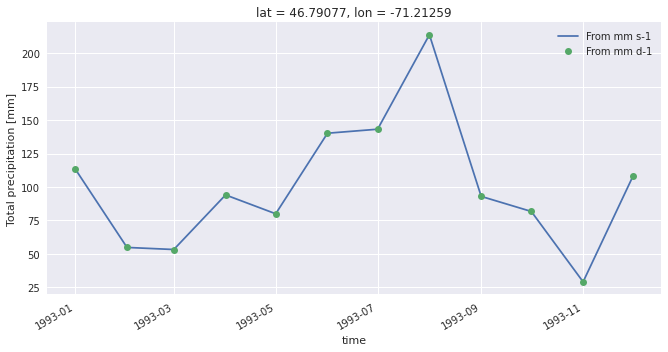

In [20]:
plt.figure()
out1.plot(label='From mm s-1', linestyle='-')
out2.plot(label='From mm d-1', linestyle='none', marker='o')
plt.legend()

### Threshold indices

`xclim` unit handling also applies to threshold indicators. Users can provide threshold in units of choice and `xclim` will adjust automatically. For example determining the number of days with tasmax > 20°C users can define a threshold input of '20 C' or '20 degC' even if input data is in Kelvin. Alernatively users can even provide a threshold in Kelvin '293.15 K' (if they really wanted to).

/home/tjs/git/xclim/xclim/indicators/atmos/_temperature.py:87: UserWarning: Variable does not have a `cell_methods` attribute.
  cfchecks.check_valid(tasmax, "cell_methods", "*time: maximum within days*")
/home/tjs/miniconda3/envs/xclim38/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/home/tjs/git/xclim/xclim/indicators/atmos/_temperature.py:87: UserWarning: Variable does not have a `cell_methods` attribute.
  cfchecks.check_valid(tasmax, "cell_methods", "*time: maximum within days*")
/home/tjs/git/xclim/xclim/indicators/atmos/_temperature.py:88: UserWarning: Variable does not have a `standard_name` attribute.
  cfchecks.check_valid(tasmax, "standard_name", "air_temperature")
/home/tjs/miniconda3/envs/xclim38/lib/python3.8/site-package

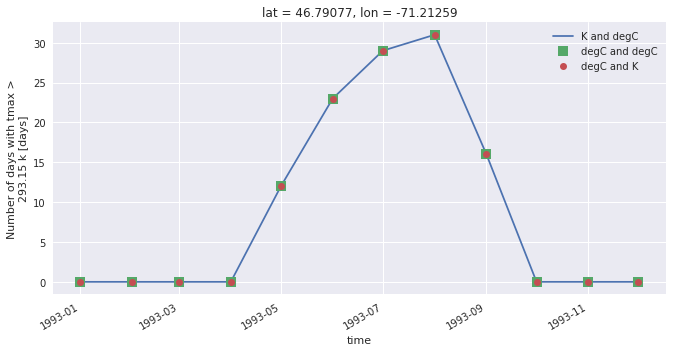

In [21]:
# Create a copy of the data converted to C
tasmax_C = ds4.tasmax - 273.15
tasmax_C.attrs['units'] = 'C'

# Using Kelvin data, threshold in Celsius
out1 = xc.atmos.tx_days_above(ds4.tasmax, thresh='20 C', freq='MS')

# Using Celsius data
out2 = xc.atmos.tx_days_above(tasmax_C, thresh='20 C', freq='MS')

# Using Celsius but with threshold in Kelvin
out3 = xc.atmos.tx_days_above(tasmax_C, thresh='293.15 K', freq='MS')

# Plot and see that it's all identical:
plt.figure()
out1.plot(label='K and degC', linestyle='-')
out2.plot(label='degC and degC', marker='s', markersize=10, linestyle='none')
out3.plot(label='degC and K', marker='o', linestyle='none')
plt.legend()